# Тестовое задание
Написать и обучить модель-автокодировщик на датасете на выбор: CIFAR10, CIFAR100.
Обучить модель-классификатор на латентных представлениях обученного автокодировщика.


### Рекомендуемые шаги для выполнения задания

**Шаг 1.** Подготовка инфраструктуры.

Создание окружения, организация структуры репозитория, загрузка датасетов.

**Шаг 2.** Реализовать модель-автоенкодер.

Выбрать архитектуру и реализовать ее совместно с процедурой обучения, подходящей для выбранного датасета.
Важно обратить внимание на выбор размерность скрытого состояния. Обосновать свой выбор.

**Шаг 3.** Обучить автоенкодер.

Нужно обучить реализованную архитектуру на скаченном датасете.
Оценить качество работы модели.

**Шаг 4.** Реализовать модель-классификатор.

Реализовать небольшую модель классификатор на скрытых представлениях уже обученного автоенкодера.
Реализовать пайплайн обучения данной модели.

**Шаг 5.** Обучение модели классификатора и визуализация результатов.

На этом шаге требуется обучить модель классификатор и оценить ее качество.
Подумайте, в каком виде было бы удобно провести демонстрацию результатов?

**Шаг 6.** Выводы и идеи.

Проведите анализ результатов, сделайте несколько выводов на основе полученных рузультатов.
Предложите свои идеи, как можно улучшить текущие результаты.


---
## 0. Загрузка библиотек и датасета

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import gc

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torchsummary import summary
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

import warnings
warnings.filterwarnings("ignore")

seed = 128
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# Проверка CUDA
torch.cuda.is_available()

True

In [2]:
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
valid_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())
train_dataset, valid_dataset

Files already downloaded and verified
Files already downloaded and verified


(Dataset CIFAR10
     Number of datapoints: 50000
     Root location: ./data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset CIFAR10
     Number of datapoints: 10000
     Root location: ./data
     Split: Test
     StandardTransform
 Transform: ToTensor())

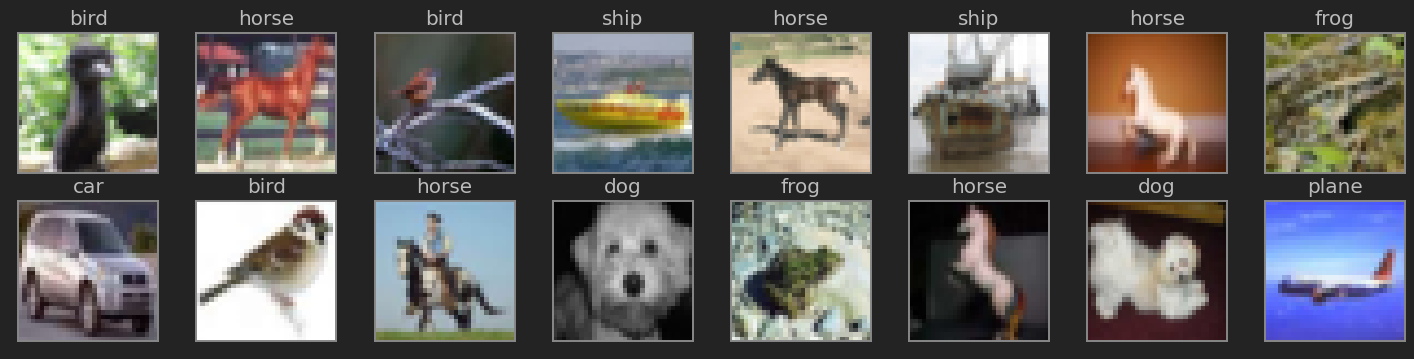

In [3]:
# Посмотрим, что внутри, добавим описание меток из оф. описания
labels_dict = {
    0: "plane",
    1: "car",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck",
}

figure = plt.figure(figsize=(18, 4))
cols, rows = 8, 2
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_dict[label])
    plt.xticks([]), plt.yticks([])
    plt.imshow(np.transpose(img, axes=(1, 2, 0)))
plt.show()

In [4]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=512,
                                           shuffle=True,
                                          )
valid_loader = torch.utils.data.DataLoader(valid_dataset, 
                                          batch_size=512,
                                          shuffle=False, 
                                         )

---
## 1. Реализация структуры сети автоэнкодера на основе VGG16

In [5]:
transfer_model = models.vgg16(pretrained=True)
transfer_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [6]:
# VGG уже с обученными весами и обычно первые слои в моделях с похожими задачами схожи между собой - извлекают низкоуровневые фичи.
# Поэтому зафиксируем слои VGG и не будем их обучать.
for param in transfer_model.features.parameters():
    param.requires_grad = False
transfer_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [7]:
class Encoder(nn.Module):
    def __init__(self, hidden_dim):
        super(Encoder, self).__init__()
        self.vgg16 = transfer_model.features
        self.flat = nn.Flatten()
        self.fc = nn.Linear(512*1*1, 128)
        self.hidden = nn.Linear(128, hidden_dim)

    def forward(self, x):
        x = self.vgg16(x)
        
        x = self.flat(x)
        x = self.fc(x)
        x = F.relu(x)
        x = self.hidden(x)
        
        return x

class Decoder(nn.Module):
    def __init__(self, hidden_dim):
        super(Decoder, self).__init__()
        self.convt_1 = nn.ConvTranspose2d(512, 512, kernel_size=2, stride=1, padding=0)
        self.convt_2 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.convt_3 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=1, padding=0)
        self.convt_4 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.convt_5 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2, padding=0)
        self.convt_6 = nn.ConvTranspose2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.convt_7 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2, padding=0)
        self.convt_8 = nn.ConvTranspose2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.convt_9 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2, padding=0)
        self.convt_10 = nn.ConvTranspose2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.convt_11 = nn.ConvTranspose2d(64, 3, kernel_size=3, stride=1, padding=1)
        self.fc = nn.Linear(128, 512*1*1)
        self.hidden = nn.Linear(hidden_dim, 128)
        self.unflat = nn.Unflatten(dim=1, unflattened_size=(512, 1, 1))
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.hidden(x)
        x = self.relu(x)
        x = self.fc(x)
        x = self.relu(x)
        x = self.unflat(x)
        
        x = self.convt_1(x)
        x = self.relu(x)
        
        x = self.convt_2(x)
        x = self.relu(x)
        x = self.convt_2(x)
        x = self.relu(x)
        
        x = self.convt_3(x)
        x = self.relu(x)
        
        x = self.convt_4(x)
        x = self.relu(x)
        x = self.convt_4(x)
        x = self.relu(x)
        
        x = self.convt_5(x)
        x = self.relu(x)
        
        x = self.convt_6(x)
        x = self.relu(x)
        x = self.convt_6(x)
        x = self.relu(x)
        
        x = self.convt_7(x)
        x = self.relu(x)
        x = self.convt_8(x)
        x = self.relu(x)

        x = self.convt_9(x)
        x = self.relu(x)
        x = self.convt_10(x)
        x = self.relu(x)
        
        x = self.convt_11(x)
        x = self.relu(x)
        
        return x

class AutoEncoder(nn.Module):
    def __init__(self, hidden_dim):
        super(AutoEncoder, self).__init__()
        self.enc = Encoder(hidden_dim)
        self.dec = Decoder(hidden_dim)
        
    def forward(self, x):
        x = self.enc(x)
        x = self.dec(x)
        
        return x

In [8]:
# Запомним device для дальнейшего использования
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [9]:
model = AutoEncoder(hidden_dim=4).to(device)
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          36,928
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
              ReLU-9          [-1, 128, 16, 16]               0
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         590,080
             ReLU-14            [-1, 25

---
## 2. Обучение автоэнкодера

In [10]:
chosen_dim = 8 # 4
model = AutoEncoder(hidden_dim=chosen_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()  

In [11]:
history = pd.DataFrame(columns=['hidden_dimension', 'epoch', 'train_loss', 'valid_loss'])
print(f'Start training with {chosen_dim}-sized hidden dimension')

for epoch in range(101):  

    # TRAIN BLOCK
    model.train()
    loss_train = 0
    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs.to(device))
        loss = criterion(outputs, inputs.to(device))
        loss.backward()
        optimizer.step()
        loss_train += loss.item()

        del inputs, labels
        gc.collect()
        torch.cuda.empty_cache()

    # EVAL BLOCK
    model.eval()
    loss_valid = 0
    with torch.no_grad():
        for X, y in valid_loader:
            output = model(X.to(device))
            loss = criterion(output, X.to(device))
            loss_valid += loss.item()

            del X, y
            gc.collect()
            torch.cuda.empty_cache()

    history.loc[len(history)] = [chosen_dim, epoch, loss_train, loss_valid]

    if (epoch % 10 == 0):
        print(f"Epoch: {epoch}, train_loss: {loss_train / len(train_loader)}, valid_loss: {loss_valid / len(valid_loader)}")

torch.save(model.to('cpu').state_dict(), f'./Models/VGG16model_{chosen_dim}-hidden_dim.pt')   
history.to_csv(f'./History/VGG16history_{chosen_dim}-hidden_dim.csv')
print(f'Training with {chosen_dim}-sized hidden dimension is finished!')
print('=' * 80)

model = model.to('cpu')
print(f'Training is finished!')

Start training with 8-sized hidden dimension
Epoch: 0, train_loss: 0.08136591820844583, valid_loss: 0.059684178233146666
Epoch: 10, train_loss: 0.04413751197256604, valid_loss: 0.04646538700908422
Epoch: 20, train_loss: 0.040029601897208056, valid_loss: 0.04471702594310045
Epoch: 30, train_loss: 0.03827106287436826, valid_loss: 0.044708000496029854
Epoch: 40, train_loss: 0.03716135876519339, valid_loss: 0.04494768474251032
Epoch: 50, train_loss: 0.03615743830343898, valid_loss: 0.04515901803970337
Epoch: 60, train_loss: 0.035397271758743694, valid_loss: 0.04637643378227949
Epoch: 70, train_loss: 0.03430647376392569, valid_loss: 0.046869372203946116
Epoch: 80, train_loss: 0.03291340742488297, valid_loss: 0.04801303762942553
Epoch: 90, train_loss: 0.031335891851661156, valid_loss: 0.04886786602437496
Epoch: 100, train_loss: 0.02942175798270167, valid_loss: 0.04977438468486071
Training with 8-sized hidden dimension is finished!
Training is finished!


In [50]:
history = pd.DataFrame()
for path in glob.glob('./History/VGG16history_*.csv'):
    history = pd.concat([history, pd.read_csv(path, index_col=0, dtype={'train_loss': 'float64', 'valid_loss': 'float64'})], axis=0)
    
history['train_loss'] = history['train_loss'] / len(train_loader)
history['valid_loss'] = history['valid_loss'] / len(valid_loader)

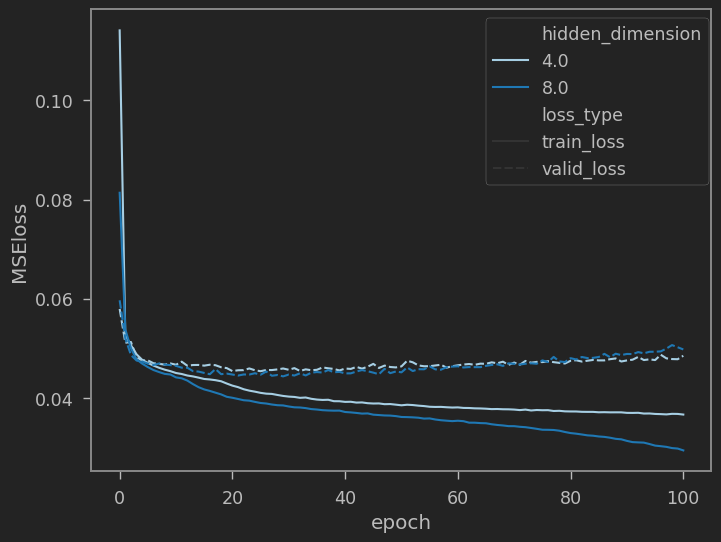

In [51]:
plt.figure(figsize=(8, 6))
sns.lineplot(data=history.melt(id_vars=['hidden_dimension', 'epoch'], 
                               value_vars=['train_loss', 'valid_loss'], 
                               var_name='loss_type',
                               value_name='MSEloss'),
             x='epoch', 
             y='MSEloss',
             hue='hidden_dimension', 
             style='loss_type',
             palette='Paired',
            )
plt.legend(bbox_to_anchor=(1.01, 1.0))
plt.show()

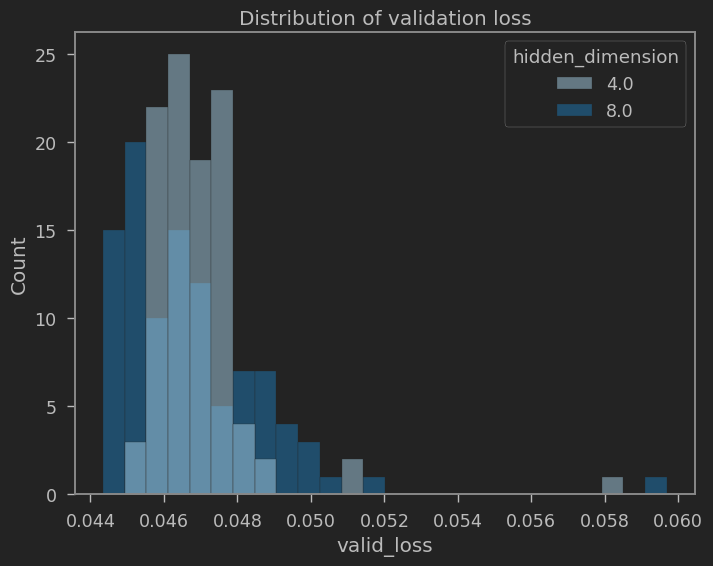

In [52]:
plt.figure(figsize=(8, 6))
sns.histplot(data=history, x='valid_loss', hue='hidden_dimension', palette='Paired')
plt.title('Distribution of validation loss')
plt.show()

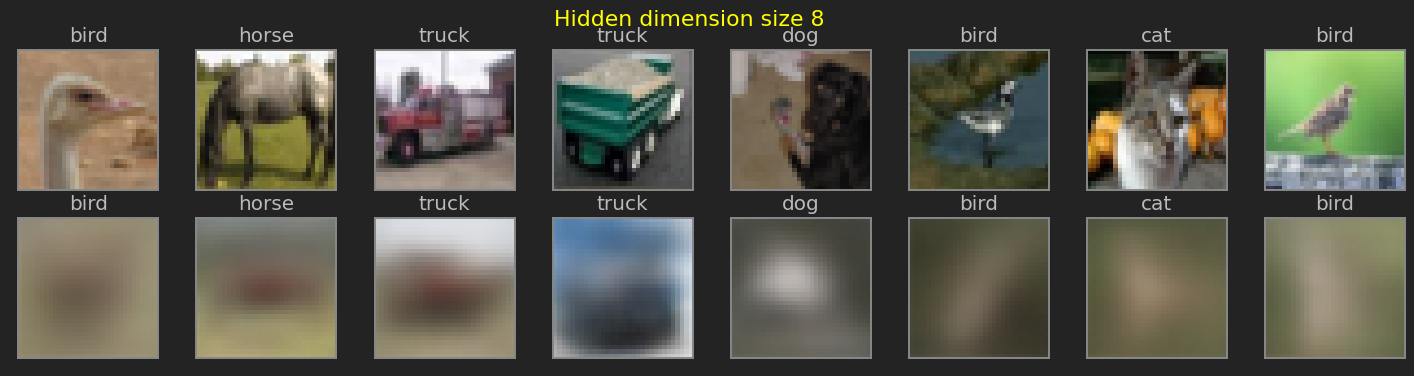

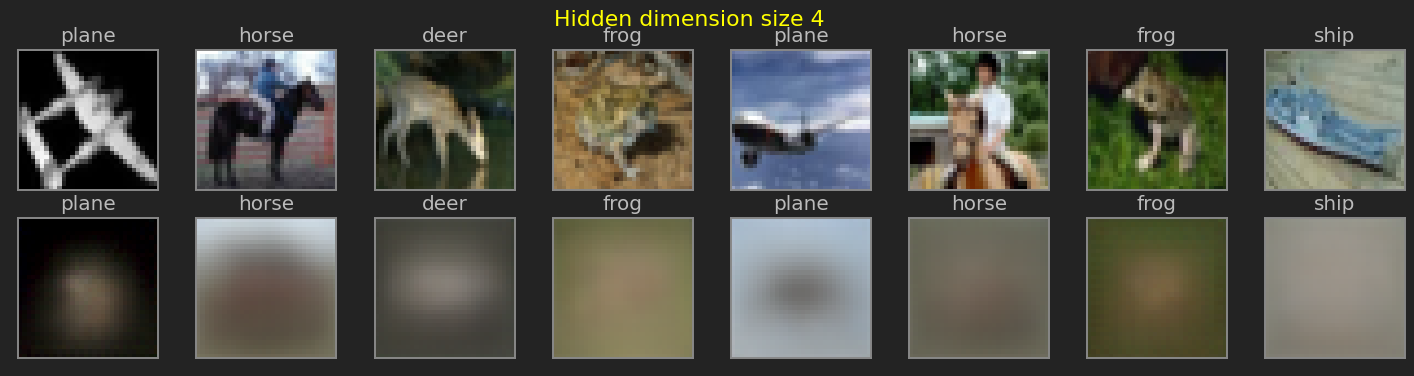

In [59]:
device = torch.device('cpu')

for chosen_dim in [8, 4]:
    model = AutoEncoder(hidden_dim=chosen_dim)
    model.load_state_dict(torch.load(f'./Models/VGG16model_{chosen_dim}-hidden_dim.pt', map_location=device))
    model = model.to(device)
    
    figure = plt.figure(figsize=(18, 4))
    cols, rows = 8, 2
    for i in range(1, cols + 1):
        sample_idx = torch.randint(len(valid_dataset), size=(1,)).item()
        img, label = valid_dataset[sample_idx]
        prediction = model(img[None, :, :, :]).detach().numpy()[0]
        prediction[prediction > 1.] = 1.

        figure.add_subplot(rows, cols, i)
        plt.title(labels_dict[label])
        plt.xticks([]), plt.yticks([])
        plt.imshow(np.transpose(img, axes=(1, 2, 0)))

        figure.add_subplot(rows, cols, i+8)
        plt.title(labels_dict[label])
        plt.xticks([]), plt.yticks([])
        plt.imshow(np.transpose(prediction, axes=(1, 2, 0)))

    plt.suptitle(f'Hidden dimension size {chosen_dim}', color='yellow')
    plt.show()

In [16]:
def draw_embeddings(X_embedded, targets, labels):
    plt.figure(figsize=(8, 6))
    for class_idx in range(np.max(targets) + 1):
        X_embedded_class = X_embedded[targets == class_idx, :]
        plt.scatter(X_embedded_class[:, 0], X_embedded_class[:, 1])
    plt.legend(labels, bbox_to_anchor=(1.01, 1.0))
    plt.grid(True)

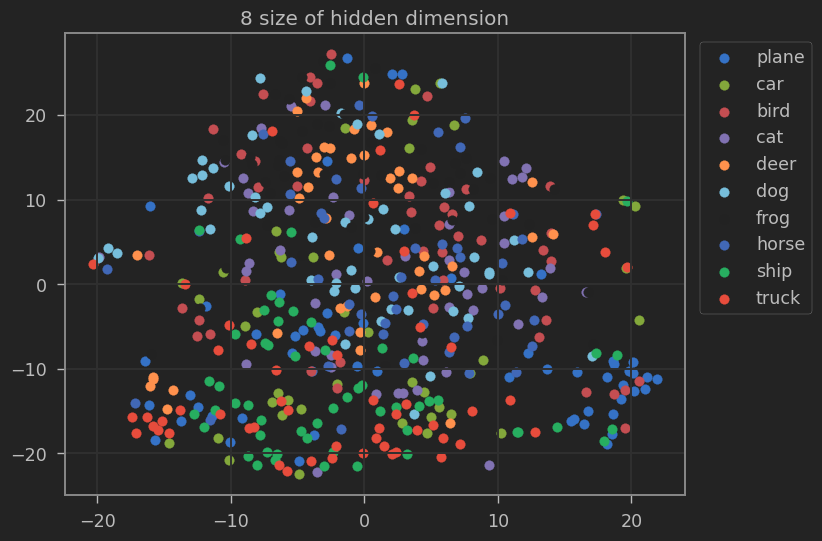

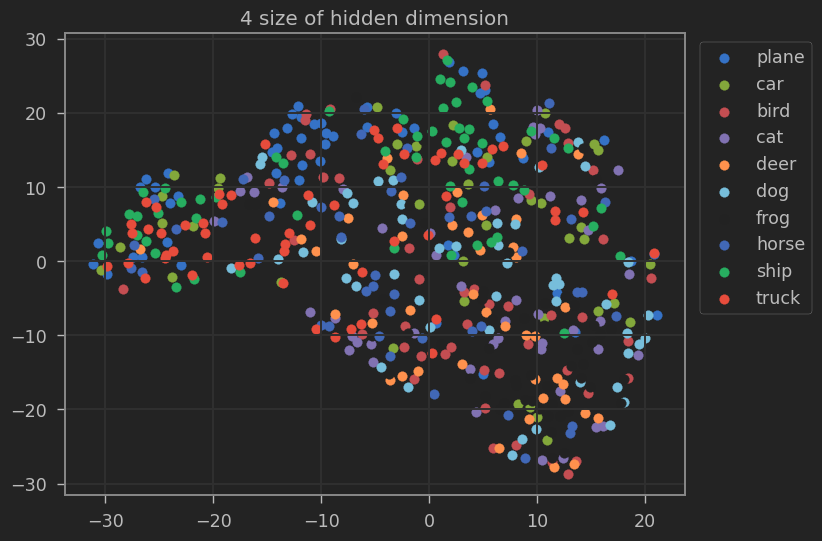

In [60]:
dataloader_iterator = iter(valid_loader)
x, y = next(dataloader_iterator)

for chosen_dim in [8, 4]:
    model = AutoEncoder(hidden_dim=chosen_dim)
    model.load_state_dict(torch.load(f'./Models/VGG16model_{chosen_dim}-hidden_dim.pt', map_location=device))
    pretrained_encoder = model.enc
    test_embs = pretrained_encoder(x).detach().numpy()
    test_embs_2D = TSNE(n_components=2).fit_transform(test_embs)
    draw_embeddings(test_embs_2D, y.detach().numpy(), labels_dict.values())
    plt.title(f'{chosen_dim} size of hidden dimension')

### Анализ автоэнкодера
Автоэнкодер с латентным пространством 4 и 8 имеет схожие результаты. Тем не менее, для сравнения с прошлой моделью VGG11 (см. файл MIL_case_VGG.ipynb) для классификатора возьмем латентное пространство - 8

---
## 3. Реализация модели-классификатора

In [64]:
chosen_dim = 8
model = AutoEncoder(hidden_dim=chosen_dim)
model.load_state_dict(torch.load(f'./Models/VGG16model_{chosen_dim}-hidden_dim.pt', map_location=device))

# Отрежем энкодер от модели автоэнкодера и зафиксируем его параметры
pretrained_encoder = model.enc
for param in pretrained_encoder.parameters():
    param.requires_grad = False
pretrained_encoder

Encoder(
  (vgg16): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

In [65]:
class ClassificationModel(nn.Module):
    def __init__(self, input_dim):
        super(ClassificationModel, self).__init__()
        self.enc = pretrained_encoder

        self.fc_1st = nn.Linear(input_dim, 512)
        self.fc_2nd = nn.Linear(512, 1024)
        self.fc_3rd = nn.Linear(1024, 10)

    def forward(self, x):
        x = self.enc(x)

        x = self.fc_1st(x)
        x = F.relu(x)
        
        x = self.fc_2nd(x)
        x = F.relu(x)
        
        x = self.fc_3rd(x)
        
        return x

In [66]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [67]:
clas_model = ClassificationModel(input_dim=chosen_dim).to(device)
summary(clas_model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          36,928
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
              ReLU-9          [-1, 128, 16, 16]               0
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         590,080
             ReLU-14            [-1, 25

---
## 4.  Обучение модели-классификатора

In [68]:
optimizer = torch.optim.Adam(clas_model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
for epoch in range(31):  
    # TRAIN BLOCK
    clas_model.train()
    loss_train = 0
    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = clas_model(inputs.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()
        loss_train += loss.item()

        del inputs, labels
        gc.collect()
        torch.cuda.empty_cache()

    # EVAL BLOCK
    clas_model.eval()
    loss_valid = 0.
    accuracy = 0.
    total = 0.
    with torch.no_grad():
        for X, y in valid_loader:
            output = clas_model(X.to(device))
            loss = criterion(output, y.to(device))
            loss_valid += loss.item()
            
            y_pred_softmax = torch.log_softmax(clas_model(X.to(device)), dim=1)
            _, predicted = torch.max(y_pred_softmax.data, dim=1)
            total += y.size(0)
            accuracy += (predicted == y.to(device)).sum().item()

            del X, y
            gc.collect()
            torch.cuda.empty_cache()

    if (epoch % 10 == 0):
        print(f"Epoch: {epoch}, train_loss: {loss_train / len(train_loader)}, valid_loss: {loss_valid / len(valid_loader)}, valid Accuracy: {(100 * accuracy / total)}%")

clas_model = clas_model.to('cpu')
torch.save(clas_model.state_dict(), './Models/VGG16classification_model.pt')   
print(f'Training is finished!')

Epoch: 0, train_loss: 1.665903050072339, valid_loss: 1.6328477203845977, valid Accuracy: 40.19%
Epoch: 10, train_loss: 1.507959171217315, valid_loss: 1.5990679740905762, valid Accuracy: 41.39%
Epoch: 20, train_loss: 1.4580914414658839, valid_loss: 1.6110668301582336, valid Accuracy: 41.6%


In [ ]:
dataloader_iterator = iter(valid_loader)
x, y = next(dataloader_iterator)

_, predicted = torch.max(clas_model(x).data, 1)
cm = confusion_matrix(y, predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(10))
disp.plot( values_format ='.3g')
plt.show()

---
## 5. Выводы и идеи
Классификатор с энкодером VGG16 показал себя также, как и VGG11. Возможно стоит "открепить" часть последних слоев в блоке transfer encoder для тюнинга, а также увеличить блок классификации с FC слоями или попробовать увеличить hidden-dimension (т.к. декодер сработал не очень хорошо).